In [1]:
import numpy as np
import matplotlib.pyplot as plt
from rlxutils import subplots
import pandas as pd
import sys
sys.path.append("..")
from lib import data
import torch
from torch import nn
import numpy as np
import torchvision.transforms as transforms
from tqdm import tqdm

from lib import data
from lib import sar
from lib import io

from scipy.ndimage import uniform_filter

from torch.utils.data import Dataset
from loguru import logger
from lib.datamodules.components.patches import PatchesDataset
from lib.datamodules.patches import PatchesDataModule
from lib.model import mlp_cnn
from lib.datamodules import dataset

# data params


In [2]:
#base_path = "/home/rlx/data/sar-recovery"
base_path = "/home/alberto/data/data/RST2/Barcelona"
date_train = '20100520'
date_test  = '20120720'

#date_test = '20100520'
#date_train  = '20120720'


window_size = 7

# load data


In [3]:
smtr = io.load_bcn_scatter_matrix(base_path, date_train)
#smts = io.load_bcn_scatter_matrix(base_path, date_test)

#cmtr = sar.avgpool2D_complex(sar.compute_coherence_matrix(smtr), window_size = window_size)
#cmts = sar.avgpool2D_complex(sar.compute_coherence_matrix(smts), window_size = window_size)

smtr.shape

(4402, 1602, 2, 2)

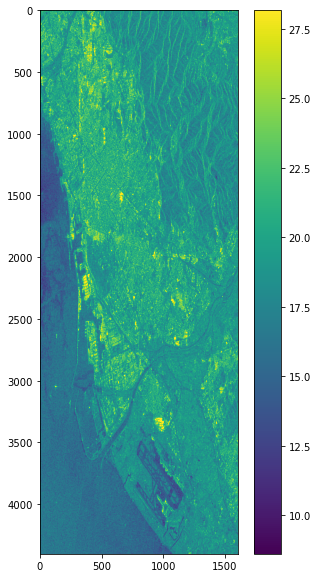

In [4]:
plt.figure(figsize=(6,10))
img = 10*np.log10(np.abs(smtr[...,0,0]))
plt.imshow(img, vmin=np.percentile(img,1), vmax=np.percentile(img,99))
plt.colorbar()

In [5]:
mask = (slice(3500, None), slice(None, 300))
smtr[mask].shape

(902, 300, 2, 2)

## Real and imag parts of S parameters follow a Gaussian distribution

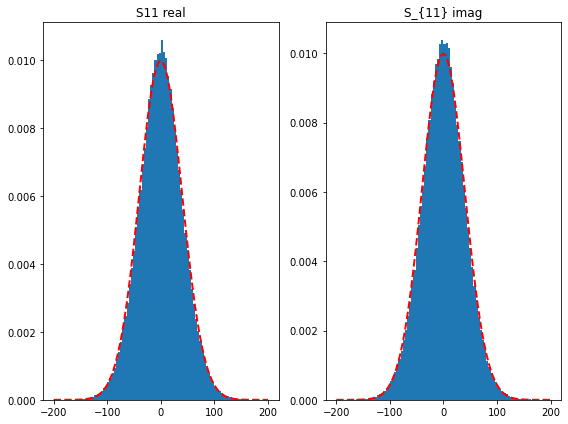

In [6]:
from scipy import stats
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,6))
data = smtr[mask][...,0,0].real.ravel()
# best fit of data
(mu, sigma) = stats.norm.fit(data)
#fig.suptitle('H/alpha unsupervised classification')
n, bins, patches = ax1.hist(data, bins=np.linspace(-200,200,101), density=True)
l = ax1.plot(bins, stats.norm.pdf(bins, mu, sigma), 'r--', linewidth=2)
ax1.set_title('S11 real')

data = smtr[mask][...,0,0].imag.ravel()
# best fit of data
(mu, sigma) = stats.norm.fit(data)
#fig.suptitle('H/alpha unsupervised classification')
n, bins, patches = ax2.hist(data, bins=np.linspace(-200,200,101), density=True)
l = ax2.plot(bins, stats.norm.pdf(bins, mu, sigma), 'r--', linewidth=2)
ax2.set_title(r'S_{11} imag')
plt.tight_layout()

# Norm of S parameters follow a Rayleigh distribution


/home/alberto/mambaforge/envs/py311/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:8687: RuntimeWarning: divide by zero encountered in divide
  s3 = (1/xm).sum()


Text(0.5, 1.0, 'S11 abs')

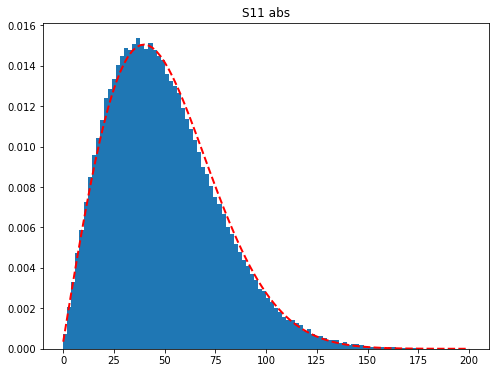

In [7]:

fig, ax1 = plt.subplots(1, 1, figsize=(8,6))
data = np.abs(smtr[mask][...,0,0]).ravel()
# best fit of data
params = stats.rayleigh.fit(data)
#fig.suptitle('H/alpha unsupervised classification')
n, bins, patches = ax1.hist(data, bins=np.linspace(0,200,101), density=True)
l = ax1.plot(bins, stats.rayleigh.pdf(bins, *params), 'r--', linewidth=2)
ax1.set_title('S11 abs')

# Intensity of S parameters follow an Exponential distribution

Text(0.5, 1.0, 'S11 intensity')

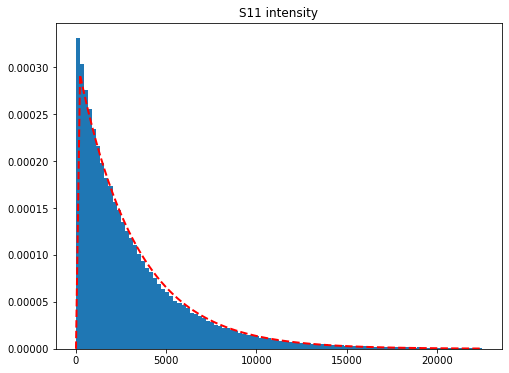

In [8]:

fig, ax1 = plt.subplots(1, 1, figsize=(8,6))
data = (np.abs(smtr[mask][...,0,0])**2).ravel()
# best fit of data
params = stats.expon.fit(data)
#fig.suptitle('H/alpha unsupervised classification')
n, bins, patches = ax1.hist(data, bins=np.linspace(0,150**2,101), density=True)
l = ax1.plot(bins, stats.expon.pdf(bins, *params), 'r--', linewidth=2)
ax1.set_title('S11 intensity')

# Statistics of the Covariance matrix elements (after spatial averaging)

In [9]:
w = np.asarray([smtr[...,0,0],  (smtr[...,0,1] + smtr[...,1,0])/np.sqrt(2), smtr[...,1,1]])

C = np.einsum("i...,j...->...ij", w, w.conj())

# Perform spatial averaging (sliding window -> Same shape)

C = uniform_filter(C, (window_size, window_size, 1, 1))
C.shape

(4402, 1602, 3, 3)

## C11 element follows a gamma distribution

(32.6686693039901, 0.5096779346095808, 512.7147299264816, 2.778480411375998)


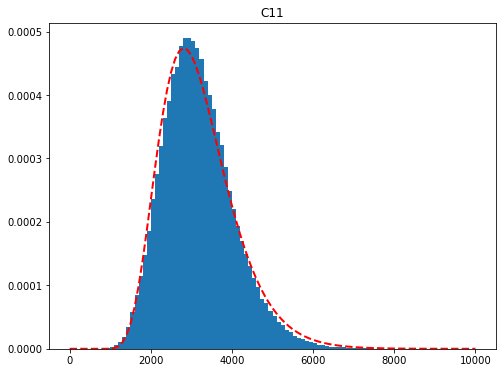

In [10]:
fig, ax1 = plt.subplots(1, 1, figsize=(8,6))
data = (C[mask][...,0,0].real).ravel()
# best fit of data
params = stats.gengamma.fit(data, window_size*window_size)
#fig.suptitle('H/alpha unsupervised classification')
n, bins, patches = ax1.hist(data, bins=np.linspace(0,100**2,101), density=True)
l = ax1.plot(bins, stats.gengamma.pdf(bins, *params), 'r--', linewidth=2)
ax1.set_title('C11')
print(params)

## log(C11) element follows a normal distribution

(34.855377, 1.2192346)


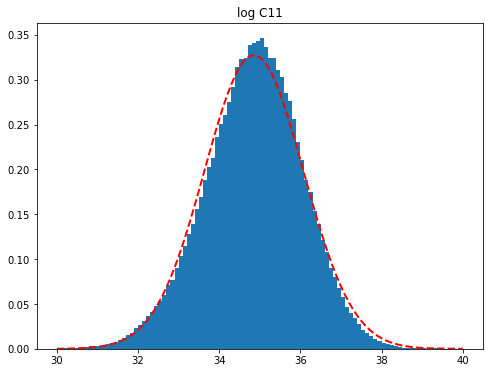

In [11]:
fig, ax1 = plt.subplots(1, 1, figsize=(8,6))
data = 10*np.log10((C[mask][...,0,0].real).ravel())
# best fit of data
params = stats.norm.fit(data)
#fig.suptitle('H/alpha unsupervised classification')
n, bins, patches = ax1.hist(data, bins=np.linspace(30, 40,101), density=True)
l = ax1.plot(bins, stats.norm.pdf(bins, *params), 'r--', linewidth=2)
ax1.set_title('log C11')
print(params)

In [12]:
# Generate normalized covariance matrices to inspect rhos
orig_dis = 1/np.sqrt(np.einsum("...ii->...i", C.real))
orig_C3_norm = np.einsum("...i,...j->...ij", orig_dis, orig_dis) * C
orig_C3_norm.shape

(4402, 1602, 3, 3)

/home/alberto/mambaforge/envs/py311/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:718: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/alberto/mambaforge/envs/py311/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:723: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  a, b = optimize.fsolve(func, (1.0, 1.0))


(85.39590806570345, 3.712137100904622, -0.10730819483130555, 1.0944051265577688)


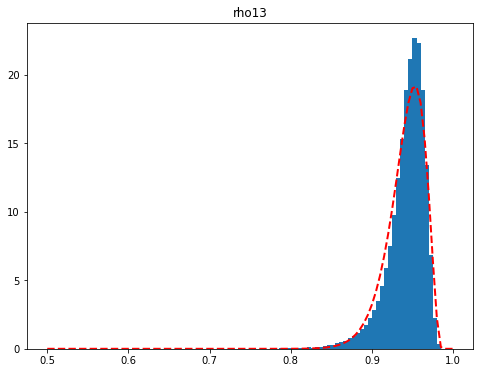

In [13]:
fig, ax1 = plt.subplots(1, 1, figsize=(8,6))
data = (np.abs(orig_C3_norm[mask][...,0,2].real)).ravel()
# best fit of data
params = stats.beta.fit(data)
#fig.suptitle('H/alpha unsupervised classification')
n, bins, patches = ax1.hist(data, bins=np.linspace(0.5,1,101), density=True)
l = ax1.plot(bins, stats.beta.pdf(bins, *params), 'r--', linewidth=2)
ax1.set_title('rho13')
print(params)

## Correlation coefficients follow a more complex distribution between [0,1] (here the fit is a beta distribution)

(1.1747455760798544, 4.767727961664829, -2.355051345617788e-05, 0.5970971352508305)


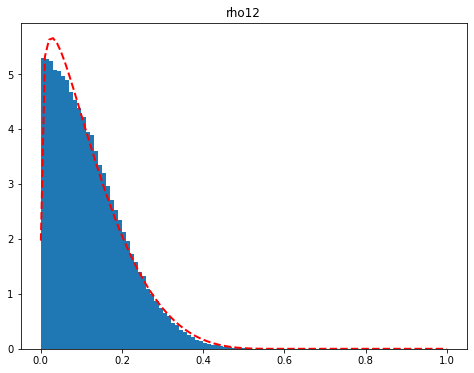

In [14]:
fig, ax1 = plt.subplots(1, 1, figsize=(8,6))
data = (np.abs(orig_C3_norm[mask][...,0,1].real)).ravel()
# best fit of data
params = stats.beta.fit(data)
#fig.suptitle('H/alpha unsupervised classification')
n, bins, patches = ax1.hist(data, bins=np.linspace(0,1,101), density=True)
l = ax1.plot(bins, stats.beta.pdf(bins, *params), 'r--', linewidth=2)
ax1.set_title('rho12')
print(params)

(1.2116958423876945, 5.272889536925792, -1.0877413604304729e-05, 0.6342220997682348)


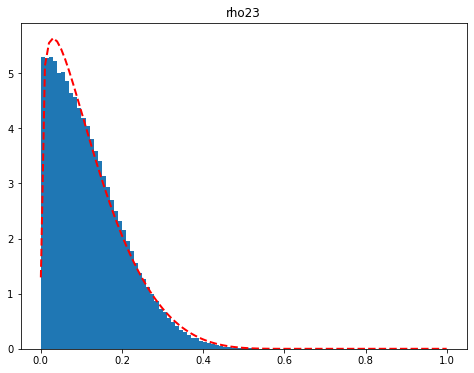

In [15]:
fig, ax1 = plt.subplots(1, 1, figsize=(8,6))
data = (np.abs(orig_C3_norm[mask][...,1,2].real)).ravel()
# best fit of data
params = stats.beta.fit(data)
#fig.suptitle('H/alpha unsupervised classification')
n, bins, patches = ax1.hist(data, bins=np.linspace(0,1,101), density=True)
l = ax1.plot(bins, stats.beta.pdf(bins, *params), 'r--', linewidth=2)
ax1.set_title('rho23')
print(params)

## Distribution of the elements of Cholesky decomposition (???)

(108.21650689343619, 0.8187900197315416, -11.857223719996451, 0.2215982159669449)


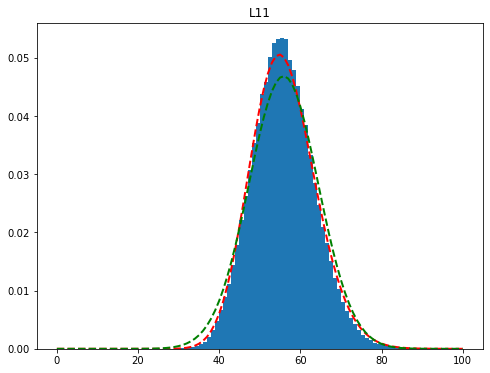

In [16]:
fig, ax1 = plt.subplots(1, 1, figsize=(8,6))
data = (np.linalg.cholesky(C[mask])[...,0,0].real).ravel()
# best fit of data - gengammma
params = stats.gengamma.fit(data, window_size*window_size)
# best fit of data - normal
params_n = stats.norm.fit(data)
#fig.suptitle('H/alpha unsupervised classification')
n, bins, patches = ax1.hist(data, bins=np.linspace(0,100,101), density=True)
l = ax1.plot(bins, stats.gengamma.pdf(bins, *params), 'r--', linewidth=2)
l = ax1.plot(bins, stats.norm.pdf(bins, *params_n), 'g--', linewidth=2)
ax1.set_title('L11')
print(params)

(25.00884268505377, 0.9867803011291814, 3.003855050065571, 0.15109724640317773)


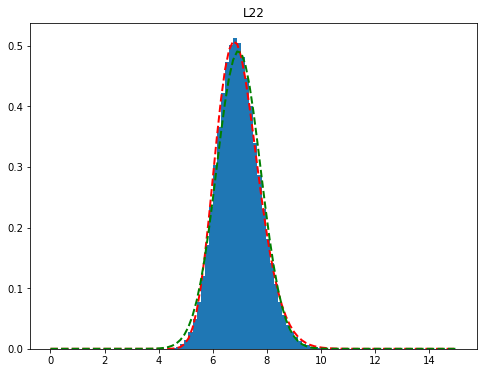

In [17]:
fig, ax1 = plt.subplots(1, 1, figsize=(8,6))
data = (np.linalg.cholesky(C[mask])[...,1,1].real).ravel()
# best fit of data - gengammma
params = stats.gengamma.fit(data, window_size*window_size)
# best fit of data - normal
params_n = stats.norm.fit(data)
#fig.suptitle('H/alpha unsupervised classification')
n, bins, patches = ax1.hist(data, bins=np.linspace(0,15,101), density=True)
l = ax1.plot(bins, stats.gengamma.pdf(bins, *params), 'r--', linewidth=2)
l = ax1.plot(bins, stats.norm.pdf(bins, *params_n), 'g--', linewidth=2)
ax1.set_title('L22')
print(params)

(17.427689, 0.6096173)


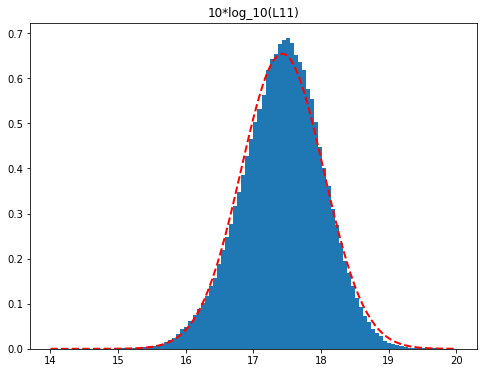

In [18]:
fig, ax1 = plt.subplots(1, 1, figsize=(8,6))
data = (10*np.log10(np.linalg.cholesky(C[mask])[...,0,0].real)).ravel()
# best fit of data - normal
params = stats.norm.fit(data)
#fig.suptitle('H/alpha unsupervised classification')
n, bins, patches = ax1.hist(data, bins=np.linspace(14,20,101), density=True)
l = ax1.plot(bins, stats.norm.pdf(bins, *params), 'r--', linewidth=2)
ax1.set_title('10*log_10(L11)')
print(params)

(8.393115, 0.49559984)


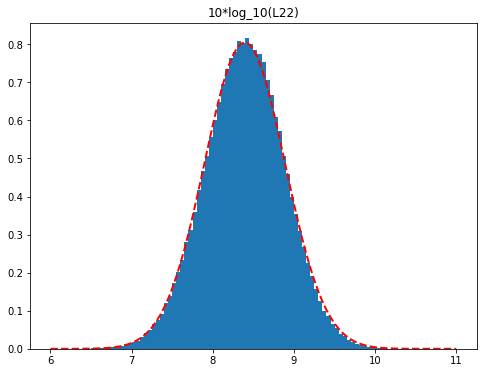

In [19]:
fig, ax1 = plt.subplots(1, 1, figsize=(8,6))
data = (10*np.log10(np.linalg.cholesky(C[mask])[...,1,1].real)).ravel()
# best fit of data - normal
params = stats.norm.fit(data)
#fig.suptitle('H/alpha unsupervised classification')
n, bins, patches = ax1.hist(data, bins=np.linspace(6,11,101), density=True)
l = ax1.plot(bins, stats.norm.pdf(bins, *params), 'r--', linewidth=2)
ax1.set_title('10*log_10(L22)')
print(params)

(-0.06778181, 1.0661086)


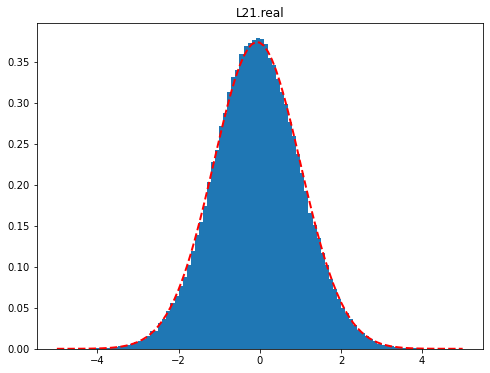

In [20]:
fig, ax1 = plt.subplots(1, 1, figsize=(8,6))
data = (np.linalg.cholesky(C[mask])[...,1,0].real).ravel()
# best fit of data - normal
params = stats.norm.fit(data)
#fig.suptitle('H/alpha unsupervised classification')
n, bins, patches = ax1.hist(data, bins=np.linspace(-5,5,101), density=True)
l = ax1.plot(bins, stats.norm.pdf(bins, *params), 'r--', linewidth=2)
ax1.set_title('L21.real')
print(params)

(0.09512698, 1.0485762)


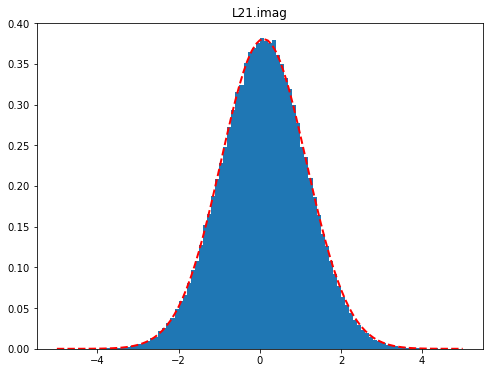

In [21]:
fig, ax1 = plt.subplots(1, 1, figsize=(8,6))
data = (np.linalg.cholesky(C[mask])[...,1,0].imag).ravel()
# best fit of data - normal
params = stats.norm.fit(data)
#fig.suptitle('H/alpha unsupervised classification')
n, bins, patches = ax1.hist(data, bins=np.linspace(-5,5,101), density=True)
l = ax1.plot(bins, stats.norm.pdf(bins, *params), 'r--', linewidth=2)
ax1.set_title('L21.imag')
print(params)

(61.16339, 10.385322)


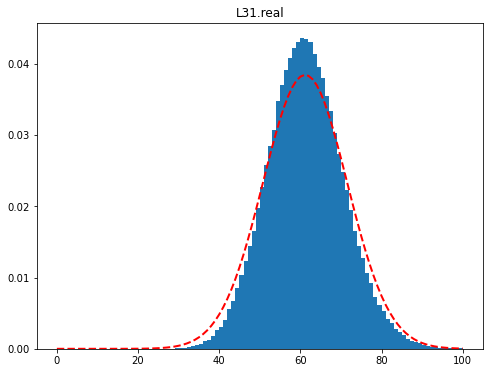

In [22]:
fig, ax1 = plt.subplots(1, 1, figsize=(8,6))
data = (np.linalg.cholesky(C[mask])[...,2,0].real).ravel()
# best fit of data - normal
params = stats.norm.fit(data)
#fig.suptitle('H/alpha unsupervised classification')
n, bins, patches = ax1.hist(data, bins=np.linspace(0,100,101), density=True)
l = ax1.plot(bins, stats.norm.pdf(bins, *params), 'r--', linewidth=2)
ax1.set_title('L31.real')
print(params)

(1.3850393, 3.4195178)


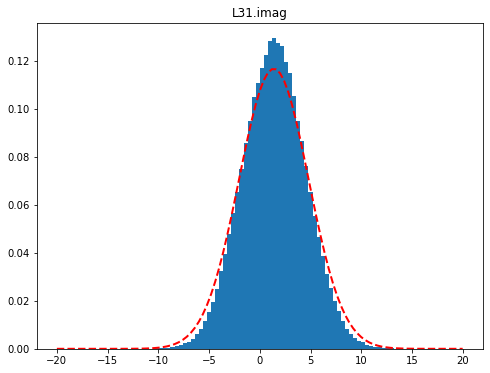

In [23]:
fig, ax1 = plt.subplots(1, 1, figsize=(8,6))
data = (np.linalg.cholesky(C[mask])[...,2,0].imag).ravel()
# best fit of data - normal
params = stats.norm.fit(data)
#fig.suptitle('H/alpha unsupervised classification')
n, bins, patches = ax1.hist(data, bins=np.linspace(-20,20,101), density=True)
l = ax1.plot(bins, stats.norm.pdf(bins, *params), 'r--', linewidth=2)
ax1.set_title('L31.imag')
print(params)